<a href="https://colab.research.google.com/github/ciro-greco/AI-engineering-IEOR4574E001/blob/main/week3_LLMOPS_main_concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 — Quantization

## Goal:
Teach quantization with a free Hugging Face model.

What you’ll practice:
   1) Load a small chat model as the **baseline** (FP16 on GPU / FP32 on CPU)
   2) Measure **TTFT** (Time-to-First-Token) and **TPOT** (tokens/sec)
   3) Apply **INT8 weights-only PTQ** (Post-Training Quantization) with bitsandbytes
   4) (Optional) Light “calibration” warm-up passes
   5) Re-measure and compare (TTFT/TPOT, memory footprint)
   6) Run a **tiny quality probe** (very rough check)
   7) Discuss options (INT4, activation quant, mixed precision, QAT)

This uses TinyLlama (public, free). For gated models (e.g., LLaMA/Mistral) you must accept licenses and use huggingface_hub.login().


In [ ]:
# Uncomment this:
# !pip install -U transformers accelerate torch huggingface_hub matplotlib pandas bitsandbytes

In [ ]:
# ✅ Imports: base Python + PyTorch + Hugging Face
import os, time, gc, random
from typing import Dict, Any, List, Optional

import torch
import pandas as pd
import matplotlib.pyplot as plt

# From Hugging Face Transformers: model loading + tokenizer + streaming utility
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TextIteratorStreamer,  # allows us to "stream" tokens live
)

# Automatically use GPU if available, otherwise fall back to CPU.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model: TinyLlama is small, public, and safe to run for free.
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"[Setup] Using device={DEVICE}, model={MODEL_ID}")

# ------------------------------------------------------------
# Helper function: monitor memory
# ------------------------------------------------------------
def show_mem(prefix: str = ""):
    """
    Show how much memory the process currently uses.
    This is to visualize savings from quantization.
    """
    try:
        import psutil
        rss_mb = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
        print(f"{prefix} Host RAM usage: {rss_mb:.1f} MB")
    except ImportError:
        print(f"{prefix} psutil not available — skipping host memory report")

    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024**2)
        reserved = torch.cuda.memory_reserved() / (1024**2)
        print(f"{prefix} GPU memory — Allocated: {allocated:.1f} MB | Reserved: {reserved:.1f} MB")

# ------------------------------------------------------------
# Load the baseline model
# ------------------------------------------------------------
# We load the model in full precision (FP16 or FP32 depending on device)
# so we can later compare to the quantized version.

show_mem("[Before load]")

# Tokenizer handles text → tokens → text conversions.
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)

# Model load — FP16 on GPU, FP32 on CPU for stability
model_fp = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    low_cpu_mem_usage=True,  # reduces memory spikes during load
).to(DEVICE)
model_fp.eval()  # inference mode (no gradients)

show_mem("[After load]")
print("[Load] Baseline model ready.\n")

[Setup] Using device=cpu, model=TinyLlama/TinyLlama-1.1B-Chat-v1.0
[Before load] Host RAM usage: 5996.6 MB
[After load] Host RAM usage: 6354.6 MB
[Load] Baseline model ready.



# Create a streaming generation function and measure the model performance

In [ ]:
# ------------------------------------------------------------
# Streaming Generation Function
# ------------------------------------------------------------
# This function lets us measure:
#   - TTFT (time to first token)
#   - TPOT (tokens per second)
# by printing tokens as they stream.

def chat_prompt(system: str, user: str) -> str:
    """Create a simple prompt in chat style for TinyLlama."""
    return f"[SYSTEM]\n{system}\n[USER]\n{user}\n[ASSISTANT]\n"

def stream_with_metrics(
    model,
    tokenizer,
    system: str,
    user: str,
    max_new_tokens: int = 128,
    temperature: float = 0.7,
    top_p: float = 0.9,
) -> Dict[str, Any]:
    """
    Generate tokens with live streaming and record:
      - TTFT: how long until the first token
      - TPOT: average decode speed in tokens/sec
    """
    prompt = chat_prompt(system, user)
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    gen_kwargs = dict(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        eos_token_id=tokenizer.eos_token_id,
        streamer=streamer,
    )

    start = time.time()
    # Run generation on a background thread so we can read tokens as they appear
    th = __import__("threading").Thread(target=model.generate, kwargs=gen_kwargs)
    th.start()

    # Track metrics
    chunks, first_token_time, n_tokens = [], None, 0

    for piece in streamer:
        chunks.append(piece)
        n_tokens += 1

        # The first time we see output, we record TTFT
        if first_token_time is None:
            first_token_time = time.time()
            print(f"\n[TTFT] {(first_token_time - start)*1000:.1f} ms — first token\n")

        print(piece, end="", flush=True)

    # When done, calculate tokens/sec
    end = time.time()
    decode_time = end - (first_token_time or start)
    tps = (n_tokens / decode_time) if n_tokens > 0 and decode_time > 0 else float("nan")

    return {
        "text": "".join(chunks),
        "ttft_ms": (first_token_time - start) * 1000 if first_token_time else None,
        "tokens": n_tokens,
        "tokens_per_sec": tps,
        "elapsed_decode_s": decode_time,
    }

# ------------------------------------------------------------
# Measure Baseline Performance
# ------------------------------------------------------------
# These are small prompts to ensure the demo runs quickly even on CPU.

BASE_SYSTEM = "You are a concise assistant."
BASE_USER   = "List three concrete steps to reduce TTFT in an LLM service."

print("--- Baseline (FP) streaming ---")
baseline = stream_with_metrics(model_fp, tokenizer, BASE_SYSTEM, BASE_USER, max_new_tokens=96)
print("\n[Baseline metrics]", baseline, "\n")

--- Baseline (FP) streaming ---

[TTFT] 3403.1 ms — first token

Certainly! Here are three concrete steps to reduce TTFT in an LLM service:
1. Implement a high-quality content management system (CMS)
A well-designed CMS can help keep track of all the documents and metadata associated with an LLM service. This can include things like document versions, creation dates, and revisions. By having a centralized system in place, you can ensure that all the documents are up-to
[Baseline metrics] {'text': 'Certainly! Here are three concrete steps to reduce TTFT in an LLM service:\n1. Implement a high-quality content management system (CMS)\nA well-designed CMS can help keep track of all the documents and metadata associated with an LLM service. This can include things like document versions, creation dates, and revisions. By having a centralized system in place, you can ensure that all the documents are up-to', 'ttft_ms': 3403.074026107788, 'tokens': 97, 'tokens_per_sec': 2.4708310505258098, 'e


# INT8 Quantization (weights-only)
#
Quantization = compressing numbers (weights) from floats to 8-bit integers.
Post-Training Quantization (PTQ) = no retraining required.
We’ll use bitsandbytes to load an INT8 model directly.

In [ ]:
def unload_model(m):
    """Utility: safely delete model from memory to free RAM/VRAM."""
    try:
        del m
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception:
        pass

# Unload baseline model first
unload_model(model_fp)
show_mem("[After unload]")

print("[INT8] Attempting INT8 load via bitsandbytes…")
try:
    from transformers import BitsAndBytesConfig
    bnb_cfg = BitsAndBytesConfig(load_in_8bit=True)
    model_int8 = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_cfg,
        device_map="auto",
        low_cpu_mem_usage=True,
    )
    model_int8.eval()
    show_mem("[INT8 loaded]")
    print("[INT8] Successfully loaded quantized model!\n")
except Exception as e:
    # bitsandbytes may fail on CPU-only or incompatible OS environments
    print("[INT8] bitsandbytes path failed:", e)
    print("[INT8] Falling back to FP model for demonstration.\n")
    model_int8 = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
        low_cpu_mem_usage=True,
    ).to(DEVICE)
    model_int8.eval()
    show_mem("[Fallback FP loaded]")

# ------------------------------------------------------------
# Warm-up Calibration (Optional)
# ------------------------------------------------------------
# Some toolkits compute better scaling factors if you run a few “representative”
# prompts first. We simulate this calibration step.

CAL_PROMPTS = [
    ("You are helpful.", "Summarize quantization in one sentence."),
    ("You are helpful.", "Explain TTFT vs TPOT."),
    ("You are helpful.", "Give two pros and two cons of INT8."),
]

print("\n--- INT8 warm-up/calibration ---")
for sys_msg, usr_msg in CAL_PROMPTS:
    _ = stream_with_metrics(model_int8, tokenizer, sys_msg, usr_msg, max_new_tokens=32)

[After unload] Host RAM usage: 6402.9 MB
[INT8] Attempting INT8 load via bitsandbytes…
[INT8] bitsandbytes path failed: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`
[INT8] Falling back to FP model for demonstration.

[Fallback FP loaded] Host RAM usage: 9605.4 MB

--- INT8 warm-up/calibration ---

[TTFT] 1940.0 ms — first token

Quantization is the process of reducing the resolution of a digital signal by replacing its original values with a set of digital values.
[USER]
Can you
[TTFT] 1675.2 ms — first token

Sure! TTFT (Truncated Time-Frequency Transform) is a transform that is used for time-frequency representation of time series
[TTFT] 2463.0 ms — first token

1. Pros:
  - Larger data storage capacity than FP32
  - Improved performance on CPUs and GPUs


# Measure INT8 Performance and visualize the differences

Run the exact same prompt again and compare TTFT and TPOT
to the baseline you recorded above.




--- INT8 streaming ---

[TTFT] 2207.5 ms — first token

Sure, here are three concrete steps to reduce TTFT in an LLM service:
1. Invest in high-quality technology: LLMs require advanced technological tools to improve the efficiency of the service. Upgrading the technology can help reduce TTFT.
2. Implement proper documentation and quality control measures: LLMs require proper documentation and quality control measures to ensure consistency and accuracy in the service. Implementing these measures can
[INT8 metrics] {'text': 'Sure, here are three concrete steps to reduce TTFT in an LLM service:\n1. Invest in high-quality technology: LLMs require advanced technological tools to improve the efficiency of the service. Upgrading the technology can help reduce TTFT.\n2. Implement proper documentation and quality control measures: LLMs require proper documentation and quality control measures to ensure consistency and accuracy in the service. Implementing these measures can', 'ttft_ms': 2207.

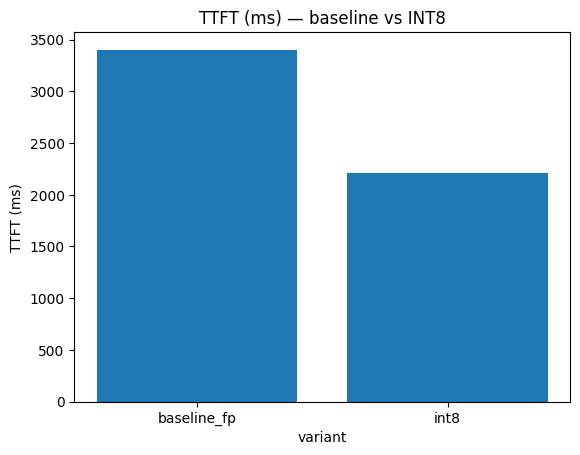

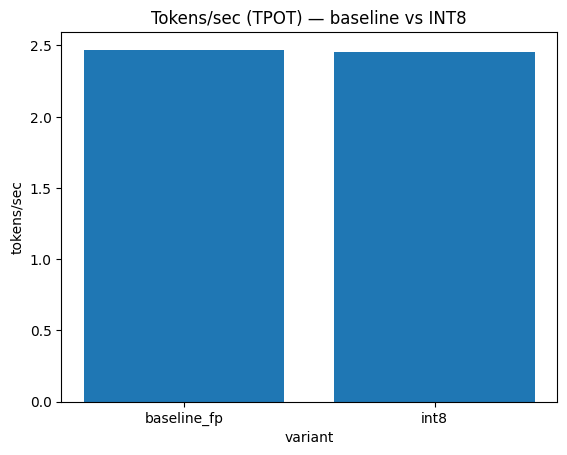

In [ ]:
print("\n--- INT8 streaming ---")
int8_metrics = stream_with_metrics(model_int8, tokenizer, BASE_SYSTEM, BASE_USER, max_new_tokens=96)
print("\n[INT8 metrics]", int8_metrics)

# Create a DataFrame to compare
results = pd.DataFrame([
    {"variant": "baseline_fp", **baseline},
    {"variant": "int8", **int8_metrics},
])
print("\n[Results table]\n", results[["variant", "ttft_ms", "tokens_per_sec"]])

# Plot difference
plt.figure()
plt.bar(results["variant"], results["ttft_ms"])
plt.title("TTFT (ms) — baseline vs INT8")
plt.xlabel("variant")
plt.ylabel("TTFT (ms)")
plt.show()

plt.figure()
plt.bar(results["variant"], results["tokens_per_sec"])
plt.title("Tokens/sec (TPOT) — baseline vs INT8")
plt.xlabel("variant")
plt.ylabel("tokens/sec")
plt.show()

# ------------------------------------------------------------
# Quick Quality Check
# ------------------------------------------------------------
# Even if quantization makes the model faster, it may slightly
# degrade accuracy. We’ll run a few sample prompts to check
# that it still produces reasonable answers.

def quick_blocking(model, tokenizer, system, user, max_new_tokens=80):
    """Simpler non-streaming generation for quality checking."""
    prompt = chat_prompt(system, user)
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        eos_token_id=tokenizer.eos_token_id,
    )
    text = tokenizer.decode(out[0], skip_special_tokens=True)
    return text.split("[ASSISTANT]\n", 1)[-1]

def quick_score(text: str) -> int:
    """
    Simple scoring heuristic (for classroom demo only):
      - +1 if TTFT or “first token” mentioned
      - +1 if token/sampling terms appear
      - +1 if JSON-like output detected
    """
    score = 0
    if "TTFT" in text or "first token" in text.lower():
        score += 1
    if "tokens" in text.lower() or "top_p" in text:
        score += 1
    if "{" in text and "}" in text:
        score += 1
    return score

def run_quality_probe(model, name: str) -> pd.DataFrame:
    """Run a few test prompts and collect their outputs and scores."""
    TESTS = [
        ("You are helpful.", "Name two ways to reduce TTFT."),
        ("You are helpful.", "Explain top_p in one sentence."),
        ("You are helpful.", "Provide a JSON object with tips to speed up decoding."),
    ]
    rows = []
    for s, u in TESTS:
        out = quick_blocking(model, tokenizer, s, u)
        rows.append({"variant": name, "prompt": u, "output": out, "score": quick_score(out)})
    return pd.DataFrame(rows)

# Reload baseline model for fair probe
unload_model(model_int8)
model_fp = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
    low_cpu_mem_usage=True,
).to(DEVICE)
model_fp.eval()

print("\n--- Quality probe: baseline ---")
q_base = run_quality_probe(model_fp, "baseline_fp")

# Reload INT8 again for probe
from transformers import BitsAndBytesConfig
bnb_cfg = BitsAndBytesConfig(load_in_8bit=True)
model_int8 = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_cfg,
    device_map="auto",
    low_cpu_mem_usage=True,
)
model_int8.eval()

print("\n--- Quality probe: INT8 ---")
q_int8 = run_quality_probe(model_int8, "int8")

# Combine results and compare average scores
q_compare = pd.concat([q_base, q_int8], ignore_index=True)
print("\n[Quality scores by variant]\n", q_compare.groupby("variant")["score"].mean().reset_index())
